In [1]:
# Setting the PythonPath
import os
import sys

# # Get the parent directory of the current working directory
parent_dir = os.path.dirname(os.getcwd())

# Add the current directory to PYTHONPATH
if parent_dir not in sys.path:
    sys.path.append(parent_dir)

In [95]:
import math
import torch
import gpytorch
from matplotlib import pyplot as plt

%matplotlib inline
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# A 1D example

## Setting up the example: target function y = sin(2 pi x) + eps

In [96]:
# Training data is 100 points in [0,1] inclusive regularly spaced
train_x = torch.linspace(0, 1, 100)
# True function is sin(2*pi*x) with Gaussian noise
train_y = torch.sin(train_x * (2 * math.pi)) + torch.randn(train_x.size()) * math.sqrt(0.04)

In [97]:
# initialize likelihood and model
likelihood = gpytorch.likelihoods.GaussianLikelihood()
kernel = gpytorch.kernels.RBFKernel()

model = GPModel(train_x=train_x, train_y=train_y, likelihood=likelihood, kernel=kernel)

## Training the model

In [98]:
# this is for running the notebook in our testing framework
import os
smoke_test = ('CI' in os.environ)
training_iter = 2 if smoke_test else 50


# Find optimal model hyperparameters
model.train()
likelihood.train()

# Use the adam optimizer
optimizer = torch.optim.Adam(model.parameters(), lr=0.1)  # Includes GaussianLikelihood parameters

# "Loss" for GPs - the marginal log likelihood
mll = gpytorch.mlls.ExactMarginalLogLikelihood(likelihood, model)

for i in range(training_iter):
    # Zero gradients from previous iteration
    optimizer.zero_grad()
    # Output from model
    output = model(train_x)
    # Calc loss and backprop gradients
    loss = -mll(output, train_y)
    loss.backward()
    print('Iter %d/%d - Loss: %.3f   lengthscale: %.3f   noise: %.3f' % (
        i + 1, training_iter, loss.item(),
        model.covar_module.lengthscale.item(),
        model.likelihood.noise.item()
    ))
    optimizer.step()

Iter 1/50 - Loss: 0.951   lengthscale: 0.693   noise: 0.693
Iter 2/50 - Loss: 0.919   lengthscale: 0.644   noise: 0.644
Iter 3/50 - Loss: 0.885   lengthscale: 0.598   noise: 0.598
Iter 4/50 - Loss: 0.846   lengthscale: 0.555   noise: 0.554
Iter 5/50 - Loss: 0.802   lengthscale: 0.514   noise: 0.513
Iter 6/50 - Loss: 0.753   lengthscale: 0.475   noise: 0.474
Iter 7/50 - Loss: 0.701   lengthscale: 0.439   noise: 0.437
Iter 8/50 - Loss: 0.648   lengthscale: 0.404   noise: 0.402
Iter 9/50 - Loss: 0.597   lengthscale: 0.371   noise: 0.369
Iter 10/50 - Loss: 0.549   lengthscale: 0.341   noise: 0.339
Iter 11/50 - Loss: 0.505   lengthscale: 0.314   noise: 0.310
Iter 12/50 - Loss: 0.465   lengthscale: 0.290   noise: 0.284
Iter 13/50 - Loss: 0.427   lengthscale: 0.269   noise: 0.259
Iter 14/50 - Loss: 0.389   lengthscale: 0.252   noise: 0.236
Iter 15/50 - Loss: 0.353   lengthscale: 0.237   noise: 0.215
Iter 16/50 - Loss: 0.317   lengthscale: 0.224   noise: 0.196
Iter 17/50 - Loss: 0.282   length

## Make predictions with the model

In [100]:
# Get into evaluation (predictive posterior) mode
model.eval()
likelihood.eval()

# Test points are regularly spaced along [0,1]
# Make predictions by feeding model through likelihood
with torch.no_grad(), gpytorch.settings.fast_pred_var():
    test_x = torch.linspace(0, 1, 51)
    observed_pred = likelihood(model(test_x))

## Plot the model fit

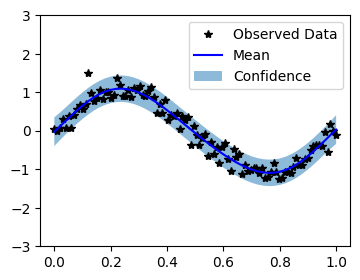

In [101]:
with torch.no_grad():
    # Initialize plot
    f, ax = plt.subplots(1, 1, figsize=(4, 3))

    # Get upper and lower confidence bounds
    lower, upper = observed_pred.confidence_region()
    # Plot training data as black stars
    ax.plot(train_x.numpy(), train_y.numpy(), 'k*')
    # Plot predictive means as blue line
    ax.plot(test_x.numpy(), observed_pred.mean.numpy(), 'b')
    # Shade between the lower and upper confidence bounds
    ax.fill_between(test_x.numpy(), lower.numpy(), upper.numpy(), alpha=0.5)
    ax.set_ylim([-3, 3])
    ax.legend(['Observed Data', 'Mean', 'Confidence'])

# A 2D example

## Setting up the example: target function y = sin(2 pi x_1) . cos(2 pi x_2) + 0.1 x_1

In [82]:
# Set the random seed for reproducibility
torch.manual_seed(42)

# Parameters
N = 200         # Number of data points
noise_std = 0.1 # Standard deviation for Gaussian noise

# Generate 2D inputs uniformly distributed in [-1, 1]
# train_x will have shape (N, 2)
train_x = 2 * torch.rand(N, 2) - 1

# Split the inputs into x1 and x2 for clarity
x1 = train_x[:, 0]
x2 = train_x[:, 1]

# Define the target function:
# y = sin(2π * x1) * cos(2π * x2) + 0.1 * x1
train_y = torch.sin(2 * torch.pi * x1) * torch.cos(2 * torch.pi * x2) + 0.1 * x1

# Add Gaussian noise to the outputs
train_y += noise_std * torch.randn(N)

# train_x has shape (N, 2) and train_y has shape (N)
print("train_x shape:", train_x.shape)
print("train_y shape:", train_y.shape)

train_x shape: torch.Size([200, 2])
train_y shape: torch.Size([200])


In [83]:
# initialize likelihood and model
likelihood = gpytorch.likelihoods.GaussianLikelihood()
kernel = gpytorch.kernels.RBFKernel()

model = GPModel(train_x=train_x, train_y=train_y, likelihood=likelihood, kernel=kernel)

## Training the model

In [84]:
# this is for running the notebook in our testing framework
import os
smoke_test = ('CI' in os.environ)
training_iter = 2 if smoke_test else 50


# Find optimal model hyperparameters
model.train()
likelihood.train()

# Use the adam optimizer
optimizer = torch.optim.Adam(model.parameters(), lr=0.1)  # Includes GaussianLikelihood parameters

# "Loss" for GPs - the marginal log likelihood
mll = gpytorch.mlls.ExactMarginalLogLikelihood(likelihood, model)

for i in range(training_iter):
    # Zero gradients from previous iteration
    optimizer.zero_grad()
    # Output from model
    output = model(train_x)
    # Calc loss and backprop gradients
    loss = -mll(output, train_y)
    loss.backward()
    print('Iter %d/%d - Loss: %.3f   lengthscale: %.3f   noise: %.3f' % (
        i + 1, training_iter, loss.item(),
        model.covar_module.lengthscale.item(),
        model.likelihood.noise.item()
    ))
    optimizer.step()

Iter 1/50 - Loss: 0.994   lengthscale: 0.693   noise: 0.693
Iter 2/50 - Loss: 0.971   lengthscale: 0.744   noise: 0.644
Iter 3/50 - Loss: 0.948   lengthscale: 0.798   noise: 0.598
Iter 4/50 - Loss: 0.926   lengthscale: 0.854   noise: 0.555
Iter 5/50 - Loss: 0.906   lengthscale: 0.912   noise: 0.513
Iter 6/50 - Loss: 0.887   lengthscale: 0.973   noise: 0.475
Iter 7/50 - Loss: 0.869   lengthscale: 1.035   noise: 0.439
Iter 8/50 - Loss: 0.854   lengthscale: 1.098   noise: 0.406
Iter 9/50 - Loss: 0.841   lengthscale: 1.163   noise: 0.375
Iter 10/50 - Loss: 0.830   lengthscale: 1.228   noise: 0.347
Iter 11/50 - Loss: 0.822   lengthscale: 1.293   noise: 0.321
Iter 12/50 - Loss: 0.817   lengthscale: 1.357   noise: 0.298
Iter 13/50 - Loss: 0.815   lengthscale: 1.421   noise: 0.278
Iter 14/50 - Loss: 0.814   lengthscale: 1.484   noise: 0.261
Iter 15/50 - Loss: 0.816   lengthscale: 1.545   noise: 0.246
Iter 16/50 - Loss: 0.819   lengthscale: 1.604   noise: 0.235
Iter 17/50 - Loss: 0.822   length

## Make predictions with the model

In [87]:
# Set the random seed for reproducibility
torch.manual_seed(42)

# Parameters for test data
N_test = 30
noise_std = 0.1  # Standard deviation for Gaussian noise

model.eval()
likelihood.eval()

N_test = 30
# Test points are regularly spaced along [0,1]
# Make predictions by feeding model through likelihood
with torch.no_grad(), gpytorch.settings.fast_pred_var():
    test_x = torch.linspace(0, 1, 51)
    
    # Generate 2D test inputs uniformly distributed in [-1, 1]
    # test_x will have shape (N_test, 2)
    test_x = 2 * torch.rand(N_test, 2) - 1
    
    # Split the inputs into x1 and x2 for clarity
    x1_test = test_x[:, 0]
    x2_test = test_x[:, 1]
    
    # Define the target function for the test set:
    # y = sin(2π * x1) * cos(2π * x2) + 0.1 * x1
    test_y = torch.sin(2 * torch.pi * x1_test) * torch.cos(2 * torch.pi * x2_test) + 0.1 * x1_test
    
    # Add Gaussian noise to the outputs
    test_y += noise_std * torch.randn(N_test)
    # Print shapes to verify
    print("test_x shape:", test_x.shape)
    print("test_y shape:", test_y.shape)

    # Compute the predictions
    observed_pred = likelihood(model(test_x))

test_x shape: torch.Size([30, 2])
test_y shape: torch.Size([30])


## Plot the model fit

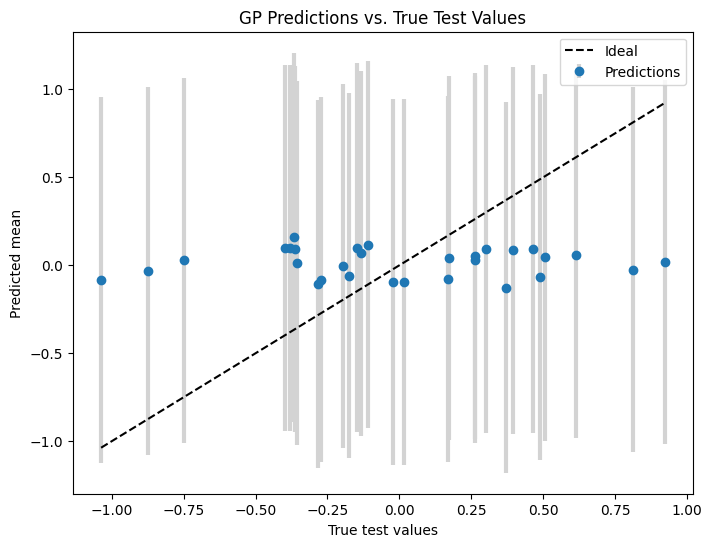

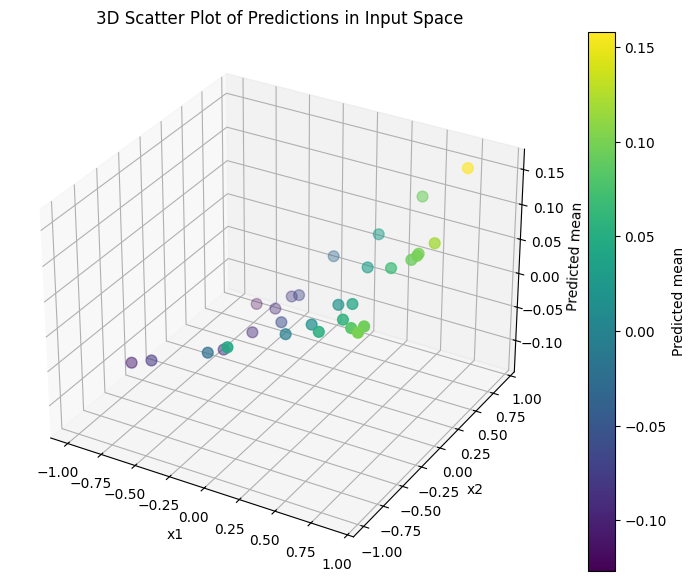

In [94]:
import matplotlib.pyplot as plt

with torch.no_grad():
    # After computing the predictions (observed_pred) as in your code:
    #   observed_pred = likelihood(model(test_x))
    # we extract the predicted mean and standard deviation
    
    # Get the predicted mean and 2-standard-deviation confidence intervals
    pred_mean = observed_pred.mean.detach().cpu()
    pred_std = observed_pred.stddev.detach().cpu()
    
    # Option 1: Plot predicted mean vs. true test values with error bars
    plt.figure(figsize=(8, 6))
    plt.errorbar(test_y.cpu(), pred_mean, yerr=2 * pred_std, fmt='o', 
                 ecolor='lightgray', elinewidth=3, capsize=0, label='Predictions')
    # Plot a reference line y = x
    plt.plot([test_y.min().item(), test_y.max().item()], 
             [test_y.min().item(), test_y.max().item()], 'k--', label='Ideal')
    plt.xlabel('True test values')
    plt.ylabel('Predicted mean')
    plt.title('GP Predictions vs. True Test Values')
    plt.legend()
    plt.show()
    
    # Option 2: If you'd like to visualize the predictions in the input space,
    # you can create a 3D scatter plot where the x and y axes are the two input dimensions,
    # and the color of each point represents the predicted mean.
    
    from mpl_toolkits.mplot3d import Axes3D  # noqa: F401
    
    fig = plt.figure(figsize=(10, 7))
    ax = fig.add_subplot(111, projection='3d')
    sc = ax.scatter(test_x[:, 0].cpu(), test_x[:, 1].cpu(), pred_mean,
                    c=pred_mean, cmap='viridis', s=60, label='Predicted Mean')
    ax.set_xlabel('x1')
    ax.set_ylabel('x2')
    ax.set_zlabel('Predicted mean')
    plt.title('3D Scatter Plot of Predictions in Input Space')
    plt.colorbar(sc, label='Predicted mean')
    plt.show()
